### Let's try to implement a VAR Model

In [348]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.api import VAR

In [362]:
def loadPrices(fn):
    global nt, nInst
    df=pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    (nt,nInst) = df.shape
    return (df.values)

pricesFile="../prices.txt"
prices = pd.DataFrame(loadPrices(pricesFile))
returns = pd.DataFrame(np.diff(np.log(prices), axis=0))
train_prices = prices.iloc[:500, :]
test_prices = prices.iloc[500:, :].reset_index(drop=True)

train_returns = returns.iloc[:500,:]
test_returns = returns.iloc[500:,:].reset_index(drop=True)

<>:3: SyntaxWarning:

invalid escape sequence '\s'

<>:3: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\sng66\AppData\Local\Temp\ipykernel_27040\1071588070.py:3: SyntaxWarning:

invalid escape sequence '\s'



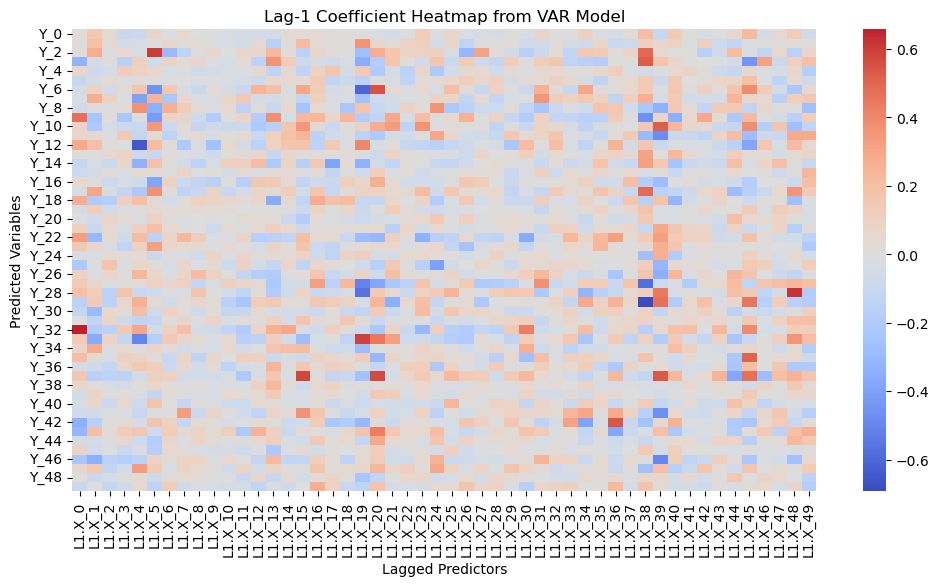

In [364]:
model = VAR(train_returns)

results = model.fit(maxlags=8,ic='aic')

coefs = results.coefs
coef_df = pd.DataFrame(coefs[0], 
          index=[f"Y_{i}" for i in range(coefs[0].shape[0])],
          columns=[f"L1.X_{j}" for j in range(coefs[0].shape[1])])

plt.figure(figsize=(12, 6))
sns.heatmap(coef_df, annot=False, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Lag-1 Coefficient Heatmap from VAR Model")
plt.xlabel("Lagged Predictors")
plt.ylabel("Predicted Variables")
plt.show()

In [365]:
forecast = results.forecast(train_returns.values[-results.k_ar:], steps=249)
forecast_returns = pd.DataFrame(forecast, columns=train_returns.columns)
forecast_returns

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.004046,-0.003900,-0.005477,0.041726,-0.025545,0.014749,0.022264,0.052011,-0.037229,-0.013617,-0.025754,0.023048,-0.032452,0.009194,2.033370e-02,-0.004070,0.017527,-0.021815,0.017320,0.010124,0.010290,-0.035049,0.009513,0.022046,0.004694,0.019526,-0.014162,0.024526,0.016455,0.002430,-0.031212,0.011399,-0.023841,-0.018266,0.004072,0.011707,-0.001799,0.022818,0.003764,-0.012376,0.000447,0.022196,0.014530,0.010774,-0.003934,-0.006502,-0.014272,-0.019339,0.018172,-0.001166
1,0.002310,-0.000748,0.011435,-0.015210,-0.001287,-0.017831,0.000485,-0.016270,0.018031,-0.020532,-0.011976,0.022214,-0.032732,-0.010176,-1.120666e-02,-0.008556,-0.006526,-0.001526,-0.029833,0.003381,-0.006520,-0.037854,0.021267,0.017648,-0.004462,-0.038998,-0.037093,0.014115,0.028285,-0.000356,0.021857,-0.048050,-0.003229,-0.004518,0.011567,-0.031465,0.009035,-0.016478,0.005661,-0.008198,0.004033,0.020958,0.027179,0.000018,-0.012288,0.008425,-0.016118,0.012332,0.011629,0.008710
2,-0.002033,0.009760,-0.010459,-0.017790,-0.008714,0.000941,-0.009972,-0.010389,-0.032129,-0.033672,-0.020077,-0.014424,0.005730,-0.005390,9.523917e-03,-0.004528,0.020559,-0.002306,-0.008317,0.021245,-0.012021,0.032303,-0.017692,-0.022171,0.011858,0.017487,-0.028644,-0.027067,0.003366,0.000270,0.013270,0.022110,0.018828,0.000031,-0.004065,-0.009796,0.006264,0.021914,-0.007538,-0.015458,-0.011159,-0.024811,0.010168,0.018988,-0.007781,0.004299,-0.007139,-0.015994,-0.002171,0.001387
3,-0.006990,-0.005023,-0.020409,0.000038,-0.018741,0.000551,-0.033135,-0.017652,0.026200,0.000929,0.006089,0.028716,-0.015243,-0.003206,2.045205e-03,0.002636,-0.019647,0.002774,-0.008471,-0.003568,-0.005441,0.005072,-0.003606,0.013857,0.010477,-0.005351,-0.015299,0.008123,-0.014078,-0.010971,-0.030620,0.014829,-0.032429,-0.005134,-0.008974,-0.015900,-0.019601,-0.019060,-0.006279,-0.016824,0.014042,0.011940,0.010045,0.016345,-0.005630,-0.002011,0.012954,-0.000896,0.006121,-0.012185
4,0.001696,-0.007249,0.003856,-0.035181,-0.008912,-0.010838,-0.028819,-0.006176,-0.001448,-0.013888,0.023777,-0.037484,0.017130,0.005195,-2.712655e-02,0.007525,-0.018211,0.018623,-0.004933,-0.005887,-0.010107,0.006672,-0.019035,0.006539,-0.000565,-0.001366,-0.004248,-0.010372,-0.000251,-0.036005,-0.003261,0.005962,-0.022023,-0.015717,0.020688,-0.004609,0.000881,-0.032840,-0.000955,-0.006799,0.014483,-0.011110,-0.015754,0.001357,0.013033,-0.003442,-0.014592,0.010207,0.010021,0.021183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,-0.000226,-0.000438,-0.000586,0.000302,-0.000516,-0.000077,-0.000832,0.000500,-0.000370,0.000090,0.000284,0.000488,0.000585,0.000147,-4.145539e-06,0.000122,-0.000450,0.000364,0.000137,-0.000231,-0.000279,0.000482,0.000227,0.000911,-0.000018,-0.000868,0.000151,0.000003,-0.000352,0.000201,-0.000371,0.000261,-0.000327,-0.001188,0.000358,-0.000308,-0.000102,-0.000651,0.000022,0.000207,0.000038,0.000144,0.000343,-0.000387,0.000098,0.000076,-0.000211,-0.000704,0.000203,0.000280
245,-0.000221,-0.000436,-0.000558,0.000313,-0.000506,-0.000073,-0.000833,0.000508,-0.000372,0.000089,0.000273,0.000478,0.000593,0.000144,-9.643724e-07,0.000127,-0.000436,0.000353,0.000140,-0.000228,-0.000279,0.000490,0.000226,0.000909,-0.000011,-0.000867,0.000161,0.000007,-0.000346,0.000210,-0.000383,0.000276,-0.000301,-0.001192,0.000353,-0.000301,-0.000095,-0.000653,0.000027,0.000206,0.000028,0.000149,0.000336,-0.000393,0.000102,0.000069,-0.000214,-0.000703,0.000208,0.000292
246,-0.000223,-0.000437,-0.000549,0.000323,-0.000507,-0.000073,-0.000812,0.000514,-0.000365,0.000072,0.000273,0.000491,0.000605,0.000154,7.931701e-07,0.000131,-0.000433,0.000350,0.000125,-0.000231,-0.000278,0.000495,0.000223,0.000912,-0.000011,-0.000877,0.000163,0.000002,-

In [366]:
mse = ((forecast_returns - test_returns) ** 2).mean()
rmse = np.sqrt(mse)
print(rmse.describe())
px.line(forecast_returns)

count    50.000000
mean      0.010301
std       0.003349
min       0.004591
25%       0.006858
50%       0.010466
75%       0.013189
max       0.015479
dtype: float64


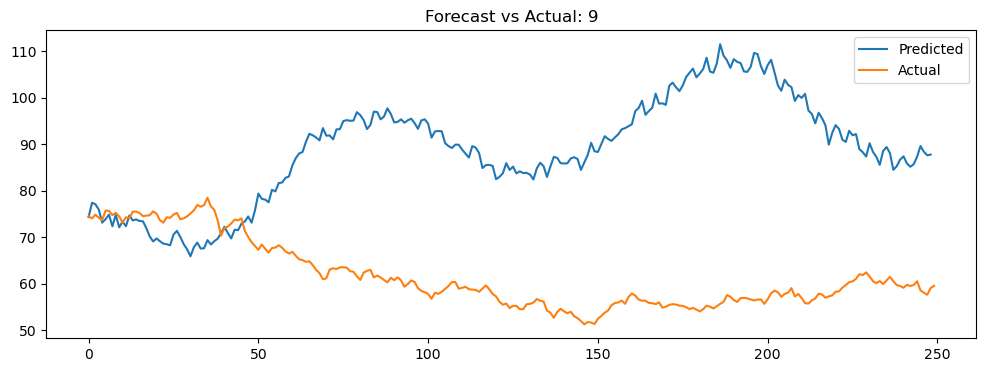

In [351]:
# Check predictions vs test 

#initialise shape
forecast_prices = forecast_returns * 0
forecast_prices.iloc[0,:] = train_prices.iloc[-1,:10] * np.exp(forecast_returns.iloc[0,:])

for i in range(1,len(forecast_prices)):
    forecast_prices.iloc[i,:] = forecast_prices.iloc[i-1,:] * np.exp(forecast_returns.iloc[i,:])

asset_index = 9

plt.figure(figsize=(12, 4))
plt.plot(forecast_prices[asset_index].values,label='Predicted')
plt.plot(test_prices[asset_index].values,label='Actual')
plt.title(f"Forecast vs Actual: {asset_index}")
plt.legend()
plt.show()


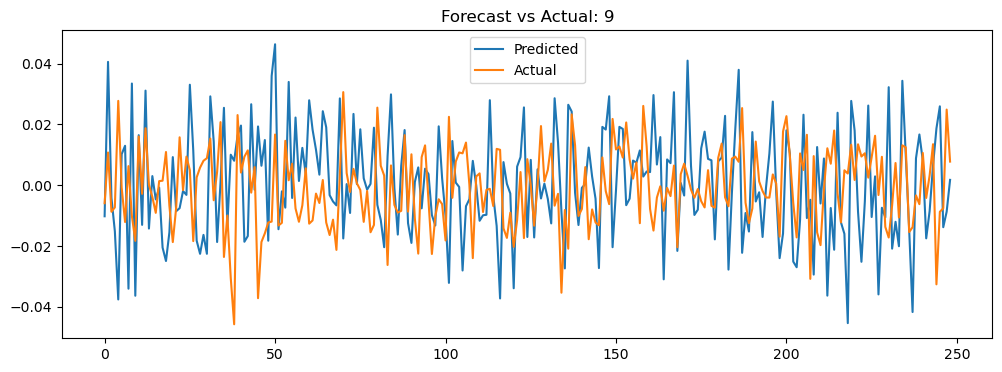

In [347]:
plt.figure(figsize=(12, 4))
plt.plot(forecast_returns[asset_index].values,label='Predicted')
plt.plot(test_returns[asset_index].values,label='Actual')
plt.title(f"Forecast vs Actual: {asset_index}")
plt.legend()
plt.show()

In [335]:
test_prices

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,34.15,58.00,47.68,36.76,51.24,27.38,23.96,55.02,36.87,74.47,32.35,61.19,37.76,57.86,53.54,54.93,48.37,34.80,42.66,29.20,43.61,42.47,83.49,105.50,74.85,33.65,45.13,27.20,51.65,33.51,24.99,74.21,38.50,11.30,55.98,40.37,60.89,42.66,71.45,69.17,76.85,44.21,35.24,29.37,84.11,29.06,69.58,17.42,81.80,32.13
1,34.45,58.00,47.66,35.72,51.24,27.44,24.49,55.77,35.90,74.03,32.09,60.44,38.25,58.05,53.07,55.03,48.54,34.92,41.30,29.18,44.02,42.84,84.07,106.21,75.18,34.00,45.29,27.43,50.61,33.51,25.15,74.42,38.74,11.42,56.23,40.16,61.00,42.84,71.05,68.81,77.26,44.75,35.72,29.40,83.78,29.18,69.38,17.14,81.38,32.38
2,34.57,58.24,47.01,35.01,50.77,27.09,24.46,56.31,36.50,74.83,32.29,61.16,38.39,58.76,52.48,55.18,48.98,34.59,41.43,29.19,44.27,42.89,83.66,107.92,75.30,33.95,45.60,27.93,49.90,33.55,25.30,75.84,39.76,11.53,56.24,40.26,61.32,43.14,71.16,69.29,77.80,43.89,35.34,29.01,84.03,29.37,68.75,17.34,81.09,32.16
3,34.60,58.75,47.17,34.85,50.86,27.09,24.30,56.53,36.31,74.18,32.88,61.49,38.38,59.41,51.70,55.87,48.51,34.08,41.54,29.31,44.05,42.77,83.91,107.67,75.96,34.76,45.22,28.27,50.80,33.41,25.71,76.37,40.23,11.55,56.47,39.88,60.97,44.09,71.49,69.25,77.40,44.04,34.94,28.98,83.59,29.13,68.44,17.63,79.99,32.02
4,34.78,59.10,46.64,35.24,51.08,27.11,25.08,57.01,36.14,73.64,32.70,61.85,38.06,59.03,52.06,55.61,48.78,34.15,41.65,29.17,43.65,41.85,84.97,106.74,75.65,34.83,45.54,27.72,50.84,33.00,25.72,76.27,39.98,11.90,56.15,40.22,61.87,44.31,71.94,69.68,77.75,44.24,35.51,29.06,84.30,29.06,68.42,17.54,80.64,31.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,36.49,51.34,45.11,29.37,39.73,28.69,17.89,47.71,40.70,58.56,28.95,57.34,35.15,51.09,56.00,51.85,42.73,40.12,37.85,29.28,41.15,39.91,95.22,97.95,82.28,36.64,48.66,25.51,61.33,39.13,24.05,73.26,45.10,10.84,50.61,40.58,72.26,47.66,68.70,64.93,75.13,46.74,39.54,32.21,75.55,30.62,85.74,16.13,81.57,31.53
246,36.30,50.95,44.66,29.32,39.85,28.59,17.84,47.31,40.32,58.05,29.56,56.14,35.50,51.08,55.53,51.60,43.34,40.43,37.76,29.01,41.33,39.48,96.30,97.18,82.67,36.55,48.84,25.25,60.37,38.93,23.89,73.30,45.22,10.87,51.43,40.37,71.94,48.45,68.17,64.55,75.06,47.19,39.32,32.92,75.97,30.87,85.88,15.91,80.50,31.65
247,36.58,50.80,44.25,29.17,40.01,28.97,17.76,47.01,39.97,57.61,29.30,56.97,35.49,51.15,55.14,51.47,44.20,39.90,37.95,29.13,41.15,39.72,99.24,97.25,82.74,35.86,49.28,24.96,59.97,38.51,23.94,73.40,45.80,10.69,50.90,40.20,72.17,47.84,67.77,64.60,74.97,47.52,39.58,33.31,76.05,30.83,86.15,15.81,80.93,31.83
248,36.43,51.19,44.02,29.11,40.01,28.54,17.69,45.68,39.86,59.06,29.51,58.66,34.92,51.51,54.87,51.65,44.04,39.64,38.35,29.20,41.22,39.44,97.12,95.79,83.21,35.94,50.07,24.59,59.32,38.07,24.09,72.85,46.42,10.84,50.73,40.48,72.16,47.64,67.79,65.03,75.36,48.15,39.94,32.95,75.38,30.81,86.42,15.75,80.80,31.78


In [360]:
def lagged_corr(series1, series2, lag=1):
    """Compute correlation between series1 and lagged version of series2."""
    if lag > 0:
        return series1[lag:].corr(series2[:-lag])
    elif lag < 0:
        return series1[:lag].corr(series2[-lag:])
    else:
        return series1.corr(series2)

assets = returns.columns
best_corr = 0
best_pair = (None, None)
best_lag = 0

max_lag = 300  # how far forward/backward to search

for asset1 in assets:
    for asset2 in assets:
        if asset1 >= asset2:
            continue
        for lag in range(-max_lag, max_lag + 1):
            corr = lagged_corr(returns[asset1], returns[asset2], lag)
            if abs(corr) > abs(best_corr):
                best_corr = corr
                best_pair = (asset1, asset2)
                best_lag = lag

print(f"Highest lagged correlation: {best_corr:.4f}")
print(f"Pair: {best_pair[0]} (leads) → {best_pair[1]} (lags by {best_lag} days)")


Highest lagged correlation: 0.2779
Pair: 11 (leads) → 25 (lags by -300 days)


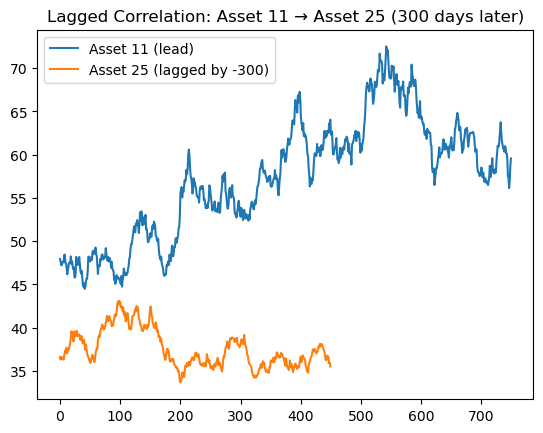

In [361]:
#Highest lagged correlation: 0.2779
#Pair: 11 (leads) → 25 (lags by -300 days)

lead = prices[11]
lag = prices[25].shift(-300)  # shift forward

plt.plot(lead, label="Asset 11 (lead)")
plt.plot(lag, label="Asset 25 (lagged by -300)")
plt.legend()
plt.title("Lagged Correlation: Asset 11 → Asset 25 (300 days later)")
plt.show()

In [ ]:
returns.columns

RangeIndex(start=0, stop=50, step=1)